# Agenda
*   Build a BERT pipeline for classification using an ML model and a pretrained BERT model for feature.
*   Compare results with classical feature transformation(extraction) techniques



In [1]:
%%capture
!pip install pytorch_pretrained_bert

In [2]:
# Import Libraries

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer, BertModel
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preperation

In [3]:
# Download the dataset
!gdown --id 1NdvIddoyYy2idsAWxJ8lodKfD-PZhmyL

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1NdvIddoyYy2idsAWxJ8lodKfD-PZhmyL
To: /content/in_domain_train.tsv
100% 429k/429k [00:00<00:00, 146MB/s]


In [4]:
# Read into a pandas dataframe
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])[['label', 'sentence']]
df

,label,sentence
0,1,"Our friends won't buy this analysis, let alone..."
1,1,One more pseudo generalization and I'm giving up.
2,1,One more pseudo generalization or I'm giving up.
3,1,"The more we study verbs, the crazier they get."
4,1,Day by day the facts are getting murkier.
...,...,...
8546,0,Poseidon appears to own a dragon
8547,0,Digitize is my happiest memory
8548,1,It is easy to slay the Gorgon.
8549,1,I had the strangest feeling that I knew you.


In [5]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values


# Bert tokenization
Apply bert tokenizer over each sentence

In [6]:
from pytorch_pretrained_bert import BertTokenizer # You will need this module

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 1237846.32B/s]


In [7]:
tokenized_texts = []
# Tokenize the sentences and put them in the list tokenized_texts
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [8]:
input_ids = []
# Convert the tokens to their index numbers (input_ids) in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]


# Create the attention mask

In [9]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [10]:
# Convert the ids into a tensor representation
batch_size = 8
input_tensor = torch.tensor(input_ids)
masks_tensor = torch.tensor(attention_masks)
train_data = TensorDataset(input_tensor, masks_tensor)
dataloader = DataLoader(train_data, batch_size=batch_size)

# Bert model
Initialize the bert model and feed in all the sentences to get the encoded vectors

In [11]:
# Initialize the model
model = BertModel.from_pretrained("bert-base-uncased").to('cuda')

100%|██████████| 407873900/407873900 [00:13<00:00, 30569781.66B/s]


In [12]:
model.eval()
outputs = []
for input, masks in dataloader:
  torch.cuda.empty_cache() # empty the gpu memory

  # Transfer the batch to gpu
  input = input.to('cuda')
  masks = masks.to('cuda')

  # Run inference on the batch
  output = model(input, output_all_encoded_layers=False, attention_mask=masks)[0]

  # Transfer the output to CPU again and convert to numpy
  output = output.cpu().detach().numpy()

  # Store the output in a list
  outputs.append(output)

# Concatenate all the lists within the list into one list
outputs = [x for y in outputs for x in y]

In [13]:
np.shape(outputs)

(8551, 128, 768)

# Aggregate the encoded represntation (use mean)





In [14]:
# prompt: Aggregate the encoded represntation (use mean)

encoded_vectors = np.mean(outputs, axis=1)
np.shape(encoded_vectors)


(8551, 768)

In [15]:
encoded_vectors

array([[ 0.38859028,  0.04454938,  0.43411404, ..., -0.02976542,
         0.0530187 , -0.06884861],
       [ 0.11730751,  0.03962048,  0.54945105, ...,  0.2545587 ,
         0.05755705,  0.17922285],
       [ 0.12119716,  0.01649856,  0.54033035, ...,  0.2554902 ,
        -0.01406734,  0.1584564 ],
       ...,
       [-0.19137388, -0.13946971,  0.06609347, ...,  0.16034941,
        -0.03729419,  0.1785153 ],
       [-0.08205759, -0.18555017,  0.21591276, ...,  0.04108167,
        -0.15756154,  0.07448574],
       [-0.17598274, -0.05458339,  0.29652733, ...,  0.33278188,
         0.12252471, -0.1877031 ]], dtype=float32)

In [16]:
!pip install umap-learn
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.2 MB/s eta 0:00:00


# Plot 2 T-sne plots, one for both representations \

> Add blockquote



In [18]:
!pip install gensim


In [19]:
from gensim.models import Word2Vec

# Train Word2Vec model on your corpus
word2vec_model = Word2Vec(sentences= tokenized_texts , vector_size=100, window=5, min_count=1, workers=4)

# Get Word2Vec embeddings for each tokenized sentence
word2vec_embeddings = []
for tokens in tokenized_texts:
    # Calculate the average embedding for each tokenized sentence
    sentence_embedding = np.mean([word2vec_model.wv[token] for token in tokens], axis=0)
    word2vec_embeddings.append(sentence_embedding)

word2vec_embeddings = np.array(word2vec_embeddings)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


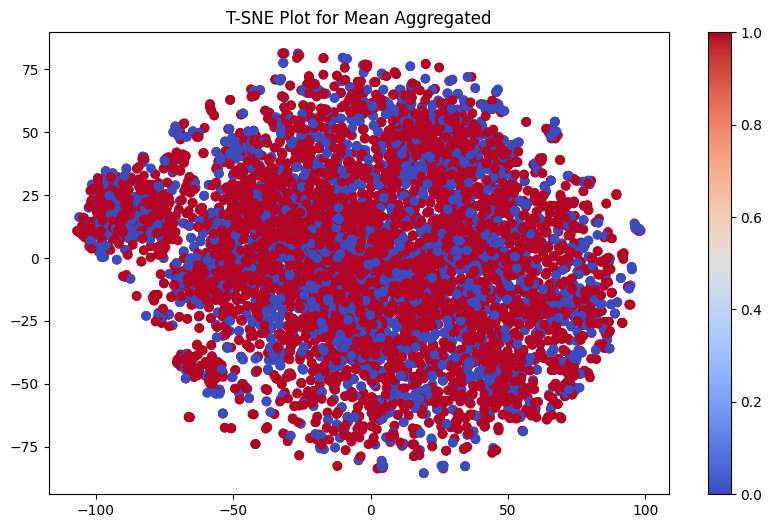

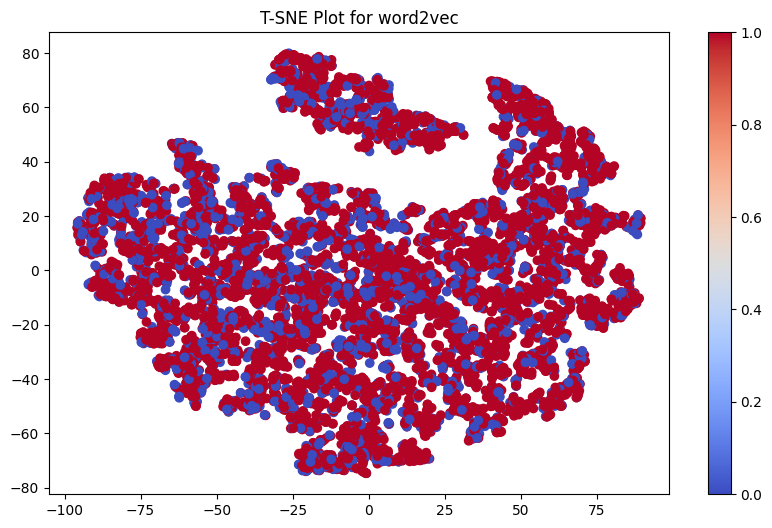

In [22]:
from sklearn.manifold import TSNE

# Define function to plot T-SNE
def plot_tsne(data, title):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_data = tsne.fit_transform(data)
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.colorbar()
    plt.show()

# Plot T-SNE for aggregated representation
plot_tsne(encoded_vectors, "T-SNE Plot for Mean Aggregated")

# T-SNE Plot for word2vec
plot_tsne(word2vec_embeddings, "T-SNE Plot for word2vec")

#  transformation (TFIDF)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Convert tokenized texts back to sentences
sentences = [' '.join(tokens) for tokens in tokenized_texts]
# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
# Fit and transform the sentences to get TF-IDF features
tfidf_embeddings = tfidf_vectorizer.fit_transform(sentences)
# Convert the sparse matrix to a dense array
tfidf_embeddings = tfidf_embeddings.toarray()


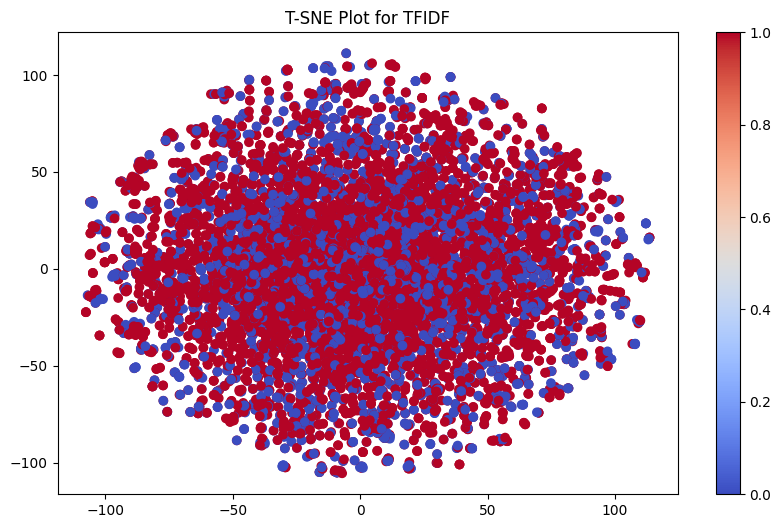

In [25]:
#T-SNE Plot for TFID
plot_tsne(tfidf_embeddings, "T-SNE Plot for TFIDF")


# Apply an Random Forest for mean.

---



In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(encoded_vectors, labels, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.18      0.28       487
           1       0.75      0.97      0.84      1224

    accuracy                           0.74      1711
   macro avg       0.71      0.57      0.56      1711
weighted avg       0.73      0.74      0.68      1711



# Apply an Random Forest for WORD 2 vec.

---



In [27]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(word2vec_embeddings, labels, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.35      0.10      0.16       487
           1       0.72      0.93      0.81      1224

    accuracy                           0.69      1711
   macro avg       0.54      0.51      0.48      1711
weighted avg       0.62      0.69      0.62      1711



# Apply an Random Forest for TFIDF

In [28]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_embeddings, labels, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.19      0.26       487
           1       0.73      0.88      0.80      1224

    accuracy                           0.68      1711
   macro avg       0.56      0.54      0.53      1711
weighted avg       0.63      0.68      0.65      1711



 ### Fine tuning the bert model

In [42]:
from transformers import BertTokenizer, BertForSequenceClassification,AdamW

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda")
#Split data (X_sentences --> sentences with cls and sep), (y_labels --> label column of data)
X_train1, X_test1, y_train1, y_test1 = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# Tokenize input sentences and format them as tensors
def tokenize_data(sentences, labels):
    input_ids = []
    attention_masks = []
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels_tensor = torch.tensor(labels)
    return input_ids, attention_masks, labels_tensor

train_inputs, train_masks, train_labels = tokenize_data(X_train1, y_train1)
test_inputs, test_masks, test_labels = tokenize_data(X_test1, y_test1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# Create data loaders

batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [46]:
# Fine-tune BERT

optimizer = AdamW(model_bert.parameters(), lr=2e-5, eps=1e-8)

epochs = 6
model_bert.to(device)

for epoch in range(epochs):
    model_bert.train()
    total_loss = 0
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        optimizer.zero_grad()
        outputs = model_bert(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_bert.parameters(), 1.0)
        optimizer.step()
    avg_train_loss = total_loss / len(train_dataloader)
    torch.cuda.empty_cache()

    model_bert.eval()
    val_accuracy = 0
    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            outputs = model_bert(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        val_accuracy += accuracy_score(label_ids, np.argmax(logits, axis=1))
    avg_val_accuracy = val_accuracy / len(test_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}, Validation Accuracy: {avg_val_accuracy}')

# Rename the fine-tuned model for clarity
FT_model = model_bert

Epoch 1/6, Training Loss: 0.505903536471251, Validation Accuracy: 0.811033950617284
Epoch 2/6, Training Loss: 0.32061165706994377, Validation Accuracy: 0.8232638888888888
Epoch 3/6, Training Loss: 0.20521319412112793, Validation Accuracy: 0.8197916666666666
Epoch 4/6, Training Loss: 0.14769349410416227, Validation Accuracy: 0.8225308641975309
Epoch 5/6, Training Loss: 0.11640184432720747, Validation Accuracy: 0.8272376543209877
Epoch 6/6, Training Loss: 0.09627863820032956, Validation Accuracy: 0.8271604938271605


In [47]:
# DataLoader after Fine Tuning
FT_model.eval()
FT_outputs = []

for input, masks in dataloader:
    torch.cuda.empty_cache()  # Empty the GPU memory

    # Transfer the batch to GPU
    input = input.to('cuda')
    masks = masks.to('cuda')

    # Run inference on the batch
    output = FT_model.bert.forward(input, output_attentions=True, attention_mask=masks, output_hidden_states=True)[0]
    # Transfer the output to CPU again and convert to numpy
    output = output.cpu().detach().numpy()

    # Store the output in a list
    FT_outputs.append(output)

# Concatenate all the arrays within the list into one array
FT_outputs = np.concatenate(FT_outputs, axis=0)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [48]:
# Aggregate by CLS token representation (first token of each sequence)
FT_cls_embeddings = FT_outputs[:, 0, :]

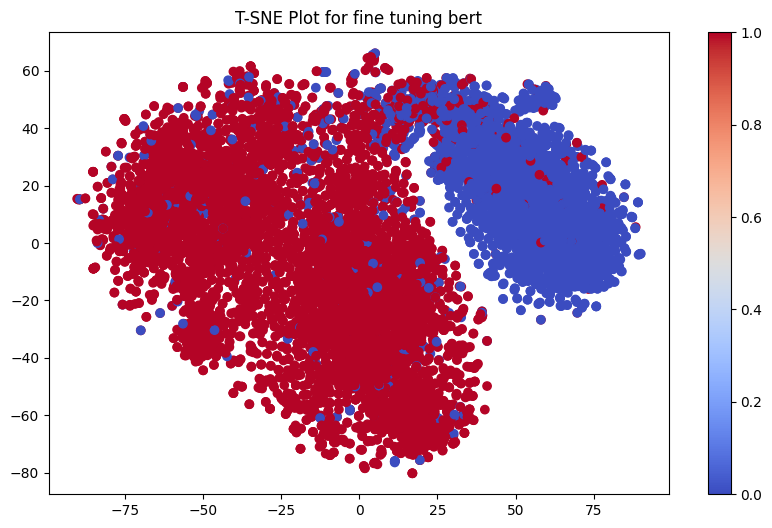

In [49]:
#T-SNE Plot for fine tuning bert
plot_tsne(FT_cls_embeddings, "T-SNE Plot for fine tuning bert")


In [56]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(FT_cls_embeddings, labels, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.62      0.66       487
           1       0.86      0.90      0.88      1224

    accuracy                           0.82      1711
   macro avg       0.78      0.76      0.77      1711
weighted avg       0.82      0.82      0.82      1711



In [68]:
import torch

# Function to get BERT [CLS] embedding
def get_cls_embedding(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return cls_embedding

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')


# New sentence to classify
new_sentence = "Digitize is my happiest memory"
new_sentence_embedding = get_cls_embedding(new_sentence, tokenizer, model_bert)

# Make a prediction with the trained model
prediction = model.predict(new_sentence_embedding)
print("Prediction for the new sentence:", prediction)

Prediction for the new sentence: [0]


In [70]:
import joblib
# Save the model to a file
joblib_file = "RandomForest_model.pkl"
joblib.dump(model , joblib_file)
print(f"Model saved to {joblib_file}")

# Load the model from a file (if needed)
loaded_model = joblib.load(joblib_file)

# Make a prediction with the loaded model
loaded_prediction = loaded_model.predict(new_sentence_embedding)
print("Prediction for the new sentence using the loaded model:", loaded_prediction)

Model saved to RandomForest_model.pkl
Prediction for the new sentence using the loaded model: [0]
